# Enviramental Setup

In [387]:
!pip install librosa numpy pandas scikit-learn matplotlib
!pip install tensorflow keras
!pip install pydub ffmpeg
import os
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, confusion_matrix, adjusted_rand_score, silhouette_score
import requests
import os
from tqdm import tqdm
from pydub import AudioSegment
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint

# Data Collection (ignore)

In [4]:
# List of bird species to download
# 麻雀, 烏鴉, 海鷗, 綠頭鴨
bird_species = [
    "Passer montanus", "Corvus macrorhynchos", "Larus canus",
    "Anas platyrhynchos"
]

max_recordings = 300
os.makedirs("data", exist_ok=True)

# Download recordings
for bird in bird_species:
    print(f"\n🔹 Downloading recordings for: {bird}...")

    save_dir = os.path.join("data", bird.replace(" ", "_"))
    os.makedirs(save_dir, exist_ok=True)
    url = f"https://xeno-canto.org/api/2/recordings?query={bird}"

    try:
        response = requests.get(url)
        response.raise_for_status()
        recordings = response.json().get("recordings", [])[:max_recordings]
    except Exception as e:
        print(f"Failed to fetch recordings for {bird}: {e}")
        continue  # Skip this bird if API fails

    with tqdm(total=len(recordings), desc=f"📥 Downloading {bird}", unit="file", leave=True) as pbar:
        for rec in recordings:
            file_url = rec.get("file")
            if not file_url:
                pbar.update(1)
                continue

            file_path = os.path.join(save_dir, f"{rec['id']}.mp3")
            
            try:
                response = requests.get(file_url)
                response.raise_for_status()
                
                with open(file_path, "wb") as f:
                    f.write(response.content)

            except Exception as e:
                print(f"❌ Failed to download {file_path}: {e}")
            
            pbar.update(1)


🔹 Downloading recordings for: Passer montanus...


📥 Downloading Passer montanus:   1%|         | 3/300 [00:18<24:48,  5.01s/file]

❌ Failed to download data/Passer_montanus/964945.mp3: 404 Client Error: Not Found for url: https://xeno-canto.org/964945/download


📥 Downloading Passer montanus:   1%|         | 4/300 [00:31<38:14,  7.75s/file]


KeyboardInterrupt: 

# Realization Dataset (ignore)

In [ ]:
def convert_mp3_to_wav(mp3_path, wav_path, max_duration=10):
    try:
        audio = AudioSegment.from_file(mp3_path, format="mp3")

        max_duration_ms = max_duration * 1000
        if len(audio) > max_duration_ms:
            audio = audio[:max_duration_ms]

        audio.export(wav_path, format="wav")
        print(f"Converted and trimmed: {mp3_path} -> {wav_path} (Max {max_duration}s)")

    except Exception as e:
        print(f"❌ Failed to convert {mp3_path}: {e}")

DATASET_PATH = "data/"

for bird_species in os.listdir(DATASET_PATH):
    species_folder = os.path.join(DATASET_PATH, bird_species)
    if os.path.isdir(species_folder):
        for file in os.listdir(species_folder):
            if file.endswith(".mp3"):
                file_path = os.path.join(species_folder, file)
                wav_path = file_path.replace(".mp3", ".wav")
                convert_mp3_to_wav(file_path, wav_path)

# Feature Extraction and Data Preprocessing

In [357]:
def augment_audio(y, sr):
    y_stretch = librosa.effects.time_stretch(y, rate=1.1)  # Speed up by 10%
    y_pitch = librosa.effects.pitch_shift(y, sr=sr, n_steps=2)  # Shift pitch
    return y_stretch, y_pitch

def extract_mfcc(file_path, aug=False):
    try:
        audio, sample_rate = librosa.load(file_path, sr=22050)
        print(f"Loaded {file_path} - Sample Rate: {sample_rate}, Length: {len(audio)}")

        # extract mfcc
        mfcc = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        mfcc_mean = np.mean(mfcc, axis=1)

        if aug:
            # Apply augmentation
            y_stretch, y_pitch = augment_audio(audio, sample_rate)

            # Extract MFCCs from augmented audio
            mfcc_stretch = librosa.feature.mfcc(y=y_stretch, sr=sample_rate, n_mfcc=40)
            mfcc_pitch = librosa.feature.mfcc(y=y_pitch, sr=sample_rate, n_mfcc=40)

            # Compute mean MFCCs
            mfcc_mean_stretch = np.mean(mfcc_stretch, axis=1)
            mfcc_mean_pitch = np.mean(mfcc_pitch, axis=1)

            # Stack all MFCCs together (original + augmented)
            return np.vstack([mfcc_mean, mfcc_mean_stretch, mfcc_mean_pitch])

        return mfcc_mean

    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

In [343]:
DATASET_PATH = "/Users/chao_hsiao/Library/CloudStorage/GoogleDrive-xsyao.ch.cs10@nycu.edu.tw/.shortcut-targets-by-id/18Ht4mEgGBL09xrKl0m0aCl35dqas4V2-/AI-capstone_HW1/data/"  # Folder containing subfolders for each bird species

features = []
labels = []

for bird_species in os.listdir(DATASET_PATH):
    species_folder = os.path.join(DATASET_PATH, bird_species)
    if os.path.isdir(species_folder):
        for file in os.listdir(species_folder):
            if file.endswith(".wav"):
                file_path = os.path.join(species_folder, file)
                mfcc_features = extract_mfcc(file_path)
                if mfcc_features is not None:
                    features.append(mfcc_features)
                    labels.append(bird_species)

df = pd.DataFrame(features)
df["label"] = labels

# save dataset
df.to_csv("bird_mfcc_dataset.csv", index=False)

Loaded /Users/chao_hsiao/Library/CloudStorage/GoogleDrive-xsyao.ch.cs10@nycu.edu.tw/.shortcut-targets-by-id/18Ht4mEgGBL09xrKl0m0aCl35dqas4V2-/AI-capstone_HW1/data/Anas_platyrhynchos/297306_part3_part1.wav - Sample Rate: 22050, Length: 220500
Loaded /Users/chao_hsiao/Library/CloudStorage/GoogleDrive-xsyao.ch.cs10@nycu.edu.tw/.shortcut-targets-by-id/18Ht4mEgGBL09xrKl0m0aCl35dqas4V2-/AI-capstone_HW1/data/Anas_platyrhynchos/485249_part5_part1.wav - Sample Rate: 22050, Length: 220500
Loaded /Users/chao_hsiao/Library/CloudStorage/GoogleDrive-xsyao.ch.cs10@nycu.edu.tw/.shortcut-targets-by-id/18Ht4mEgGBL09xrKl0m0aCl35dqas4V2-/AI-capstone_HW1/data/Anas_platyrhynchos/495820_part19_part1.wav - Sample Rate: 22050, Length: 220500
Loaded /Users/chao_hsiao/Library/CloudStorage/GoogleDrive-xsyao.ch.cs10@nycu.edu.tw/.shortcut-targets-by-id/18Ht4mEgGBL09xrKl0m0aCl35dqas4V2-/AI-capstone_HW1/data/Anas_platyrhynchos/495822_part78_part1.wav - Sample Rate: 22050, Length: 220500
Loaded /Users/chao_hsiao/Libra

KeyboardInterrupt: 

# Training(RQ1)

### Load dataset

In [348]:
df = pd.read_csv("bird_mfcc_dataset.csv")

df = df[df["10"] != 0] # remove outliers

X = df.drop(columns=["label"]).values
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df["label"])

X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

### Train an Supervised Model (Random Forest Classifier)

In [389]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_val)

# Evaluate models
print(f"Random Forest Validation Accuracy: {accuracy_score(y_val, y_pred_rf):.4f}")
print("Random Forest Confusion Matrix:")
print(confusion_matrix(y_val, y_pred_rf))

joblib.dump(rf_model, "rf_model.pkl")

Random Forest Validation Accuracy: 0.9451
Random Forest Confusion Matrix:
[[275   6   6   1]
 [  5 219   4   3]
 [  7   6 217  12]
 [  1   5   3 305]]


['rf_model.pkl']

### Train an Supervised Model (SVM)

In [391]:
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_val)

# Evaluate models
print(f"SVM Validation Accuracy: {accuracy_score(y_val, y_pred_svm):.4f}")
print("SVM Confusion Matrix:")
print(confusion_matrix(y_val, y_pred_svm))

joblib.dump(svm_model, "svm_model.pkl")

SVM Validation Accuracy: 0.8521
SVM Confusion Matrix:
[[267   8   8   5]
 [ 13 192  21   5]
 [ 16  34 181  11]
 [  1  12  25 276]]


['svm_model.pkl']

### Train an Unsupervised Model (K-Means Clustering)

K-Means Silhouette Score:	0.2510
K-Means Adjusted Rand Score:	0.1970


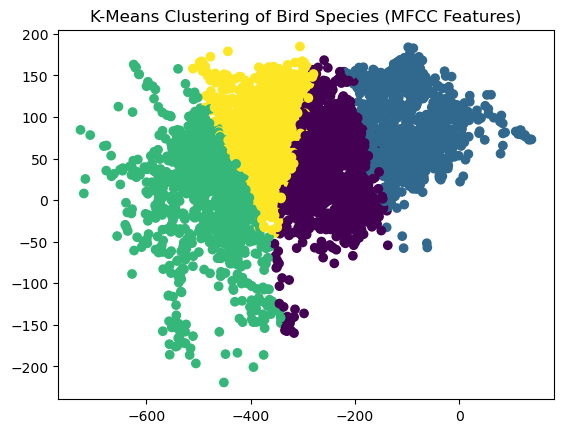

['kmeans_model.pkl']

In [392]:
kmeans = KMeans(n_clusters=len(set(y_encoded)), random_state=42, n_init=10)
y_kmeans = kmeans.fit_predict(X)
 
print(f"K-Means Silhouette Score:\t{silhouette_score(X, y_kmeans):.4f}")
print(f"K-Means Adjusted Rand Score:\t{adjusted_rand_score(y_encoded, y_kmeans):.4f}")

# Visualize clusters
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, cmap="viridis")
plt.title("K-Means Clustering of Bird Species (MFCC Features)")
plt.savefig("K-Means Clustering.png")
plt.show()

joblib.dump(kmeans_model, "kmeans_model.pkl")

### Train with Deep Learning Model

In [418]:
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.1),
    Dense(128, activation='relu'),
    Dropout(0.1),
    Dense(len(set(y_encoded)), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

checkpoint = ModelCheckpoint("nn_model.keras", monitor="val_accuracy", 
                             save_best_only=True, mode="max", verbose=1)

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), 
                    epochs=30, batch_size=16, callbacks=[checkpoint])

best_model = tf.keras.models.load_model("nn_model.keras")
y_pred_nn = np.argmax(best_model.predict(X_val), axis=1)

print(f"\nBest Neural Network Validation Accuracy: {accuracy_score(y_val, y_pred_nn):.4f}")
print("Neural Network Confusion Matrix:")
print(confusion_matrix(y_val, y_pred_nn))


Epoch 1/30


/opt/homebrew/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


236/269 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - accuracy: 0.4970 - loss: 7.6204      
Epoch 1: val_accuracy improved from -inf to 0.78419, saving model to nn_model.keras
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step - accuracy: 0.5087 - loss: 7.0642 - val_accuracy: 0.7842 - val_loss: 0.6382
Epoch 2/30
252/269 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step - accuracy: 0.7122 - loss: 0.7504
Epoch 2: val_accuracy improved from 0.78419 to 0.81488, saving model to nn_model.keras
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step - accuracy: 0.7130 - loss: 0.7485 - val_accuracy: 0.8149 - val_loss: 0.5213
Epoch 3/30
260/269 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step - accuracy: 0.7630 - loss: 0.6190
Epoch 3: val_accuracy improved from 0.81488 to 0.83628, saving model to nn_model.keras
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step - accuracy: 0.7630 - loss: 0.6191 - val_accuracy: 0.8363 - val_loss: 0.4590
Epoch 4/30
256/269 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step - accuracy: 0.7916 - loss: 0.5838
Epoch 4: val_accuracy did not improve 

# Experiments

## Experiment 1 - Effect of Training Data Size

### RF

In [156]:
percentages = [0.2, 0.4, 0.6, 0.8, 1.0]
for perc in percentages:
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    if perc == 1.0:
        X_train_sub = X_train
        y_train_sub = y_train
    else:
        X_train_sub, _, y_train_sub, _ = train_test_split(X_train, y_train, train_size=perc, random_state=42)
    
    model.fit(X_train_sub, y_train_sub)
    
    y_pred = model.predict(X_val)
    print(f"Training size: {perc*100}% - Validation Accuracy: {accuracy_score(y_val, y_pred):.4f}")

Training size: 20.0% - Validation Accuracy: 0.8819
Training size: 40.0% - Validation Accuracy: 0.9051
Training size: 60.0% - Validation Accuracy: 0.9219
Training size: 80.0% - Validation Accuracy: 0.9367
Training size: 100.0% - Validation Accuracy: 0.9451


### SVM

In [162]:
percentages = [0.2, 0.4, 0.6, 0.8, 1.0]
for perc in percentages:
    model = SVC(kernel='linear')
    if perc == 1.0:
        X_train_sub = X_train
        y_train_sub = y_train
    else:
        X_train_sub, _, y_train_sub, _ = train_test_split(X_train, y_train, train_size=perc, random_state=42)
    
    model.fit(X_train_sub, y_train_sub)
    
    y_pred = model.predict(X_val)
    print(f"Training size: {perc*100}% - Validation Accuracy: {accuracy_score(y_val, y_pred):.4f}")

Training size: 20.0% - Validation Accuracy: 0.8130
Training size: 40.0% - Validation Accuracy: 0.8288
Training size: 60.0% - Validation Accuracy: 0.8437
Training size: 80.0% - Validation Accuracy: 0.8502
Training size: 100.0% - Validation Accuracy: 0.8521


### NN

In [414]:
percentages = [0.2, 0.4, 0.6, 0.8, 1.0]
accs = []
for perc in percentages:
    model = Sequential([
        Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(0.1),
        Dense(128, activation='relu'),
        Dropout(0.1),
        Dense(len(set(y_encoded)), activation='softmax')
    ])
    
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    checkpoint = ModelCheckpoint("nn_model_e1.keras", monitor="val_accuracy", 
                                 save_best_only=True, mode="max", verbose=1)
    if perc == 1.0:
        X_train_sub = X_train
        y_train_sub = y_train
    else:
        X_train_sub, _, y_train_sub, _ = train_test_split(X_train, y_train, train_size=perc, random_state=42)
    
    history = model.fit(X_train_sub, y_train_sub, validation_data=(X_val, y_val), 
                        epochs=30, batch_size=16, callbacks=[checkpoint])
    
    best_model = tf.keras.models.load_model("nn_model_e1.keras")
    y_pred = np.argmax(best_model.predict(X_val), axis=1)
    accs.append(accuracy_score(y_val, y_pred))

for perc, acc in zip(percentages, accs):
    print(f"Training size: {perc*100}% - Validation Accuracy: {acc:.4f}")
    

Epoch 1/30


/opt/homebrew/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 1/54 ━━━━━━━━━━━━━━━━━━━━ 11s 219ms/step - accuracy: 0.2500 - loss: 46.8111
Epoch 1: val_accuracy improved from -inf to 0.62140, saving model to nn_model_e1.keras
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3844 - loss: 13.8545 - val_accuracy: 0.6214 - val_loss: 2.9690
Epoch 2/30
 1/54 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3125 - loss: 5.4712
Epoch 2: val_accuracy improved from 0.62140 to 0.73209, saving model to nn_model_e1.keras
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5694 - loss: 3.4493 - val_accuracy: 0.7321 - val_loss: 0.8980
Epoch 3/30
 1/54 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5000 - loss: 2.7562
Epoch 3: val_accuracy improved from 0.73209 to 0.77674, saving model to nn_model_e1.keras
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5878 - loss: 1.9375 - val_accuracy: 0.7767 - val_loss: 0.6796
Epoch 4/30
 1/54 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5625 - loss: 1.3078
Epoch 4: val_accuracy did not improve from 0.77674
54/54 ━

/opt/homebrew/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step - accuracy: 0.4669 - loss: 10.5480 
Epoch 1: val_accuracy improved from -inf to 0.67721, saving model to nn_model_e1.keras
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4674 - loss: 10.5156 - val_accuracy: 0.6772 - val_loss: 2.3948
Epoch 2/30
  1/108 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6875 - loss: 4.6795
Epoch 2: val_accuracy improved from 0.67721 to 0.77209, saving model to nn_model_e1.keras
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step - accuracy: 0.6163 - loss: 2.6843 - val_accuracy: 0.7721 - val_loss: 0.6549
Epoch 3/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step - accuracy: 0.6326 - loss: 1.2342
Epoch 3: val_accuracy did not improve from 0.77209
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step - accuracy: 0.6327 - loss: 1.2330 - val_accuracy: 0.7098 - val_loss: 0.7354
Epoch 4/30
  1/108 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8125 - loss: 0.6831
Epoch 4: val_accuracy improved from 0.77209 to 0.77767, saving model to nn_mo

/opt/homebrew/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


114/162 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step - accuracy: 0.4846 - loss: 9.7748  
Epoch 1: val_accuracy improved from -inf to 0.74791, saving model to nn_model_e1.keras
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step - accuracy: 0.5071 - loss: 8.4267 - val_accuracy: 0.7479 - val_loss: 0.7768
Epoch 2/30
137/162 ━━━━━━━━━━━━━━━━━━━━ 0s 368us/step - accuracy: 0.6414 - loss: 1.2483
Epoch 2: val_accuracy improved from 0.74791 to 0.75256, saving model to nn_model_e1.keras
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 596us/step - accuracy: 0.6420 - loss: 1.2169 - val_accuracy: 0.7526 - val_loss: 0.6716
Epoch 3/30
135/162 ━━━━━━━━━━━━━━━━━━━━ 0s 374us/step - accuracy: 0.6748 - loss: 0.8046
Epoch 3: val_accuracy improved from 0.75256 to 0.77116, saving model to nn_model_e1.keras
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 589us/step - accuracy: 0.6753 - loss: 0.8045 - val_accuracy: 0.7712 - val_loss: 0.5997
Epoch 4/30
139/162 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step - accuracy: 0.7169 - loss: 0.7814
Epoch 4: val_accuracy improved fr

/opt/homebrew/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


107/215 ━━━━━━━━━━━━━━━━━━━━ 0s 473us/step - accuracy: 0.4544 - loss: 7.6755  
Epoch 1: val_accuracy improved from -inf to 0.74977, saving model to nn_model_e1.keras
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step - accuracy: 0.5110 - loss: 5.8765 - val_accuracy: 0.7498 - val_loss: 0.7025
Epoch 2/30
140/215 ━━━━━━━━━━━━━━━━━━━━ 0s 360us/step - accuracy: 0.6440 - loss: 0.9380
Epoch 2: val_accuracy improved from 0.74977 to 0.80093, saving model to nn_model_e1.keras
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 533us/step - accuracy: 0.6553 - loss: 0.9070 - val_accuracy: 0.8009 - val_loss: 0.5880
Epoch 3/30
140/215 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step - accuracy: 0.7181 - loss: 0.7335
Epoch 3: val_accuracy did not improve from 0.80093
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 494us/step - accuracy: 0.7253 - loss: 0.7154 - val_accuracy: 0.7991 - val_loss: 0.5543
Epoch 4/30
125/215 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - accuracy: 0.7574 - loss: 0.6290
Epoch 4: val_accuracy improved from 0.80093 to 0.82791, saving model to 

/opt/homebrew/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


254/269 ━━━━━━━━━━━━━━━━━━━━ 0s 397us/step - accuracy: 0.5201 - loss: 5.3162
Epoch 1: val_accuracy improved from -inf to 0.76465, saving model to nn_model_e1.keras
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 677us/step - accuracy: 0.5244 - loss: 5.1616 - val_accuracy: 0.7647 - val_loss: 0.6679
Epoch 2/30
260/269 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step - accuracy: 0.6814 - loss: 0.8554
Epoch 2: val_accuracy did not improve from 0.76465
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - accuracy: 0.6820 - loss: 0.8534 - val_accuracy: 0.7507 - val_loss: 0.6159
Epoch 3/30
235/269 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - accuracy: 0.7372 - loss: 0.6863
Epoch 3: val_accuracy improved from 0.76465 to 0.79907, saving model to nn_model_e1.keras
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step - accuracy: 0.7386 - loss: 0.6817 - val_accuracy: 0.7991 - val_loss: 0.5444
Epoch 4/30
250/269 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - accuracy: 0.7625 - loss: 0.6374
Epoch 4: val_accuracy did not improve from 0.79907
269/269 ━━━━━━━━━━━━━━━

### K-Means

In [289]:
percentages = [0.2, 0.4, 0.6, 0.8, 1.0]
for perc in percentages:
    model = KMeans(n_clusters=len(set(y_encoded)), random_state=42, n_init=10)
    if perc == 1.0:
        X_sub = X
        y_sub = y_encoded
    else:
        X_sub, _, y_sub, _ = train_test_split(X, y_encoded, train_size=perc, random_state=42)
    
    y_pred = model.fit_predict(X_sub)

    print(f"Training size: {perc*100}% - ARI: {adjusted_rand_score(y_sub, y_pred):.4f}, SS:{silhouette_score(X_sub, y_pred):.4f}")

Training size: 20.0% - ARI: 0.1722, SS:0.2616
Training size: 40.0% - ARI: 0.1920, SS:0.2570
Training size: 60.0% - ARI: 0.1918, SS:0.2535
Training size: 80.0% - ARI: 0.1915, SS:0.2526
Training size: 100.0% - ARI: 0.1970, SS:0.2510


## Experiment 2 - Effect of Data Balance

### Resampling

In [544]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

### RF

In [449]:
# original model
model = joblib.load("rf_model.pkl")
y_pred = model.predict(X_val)

# trained with balanced data
model_bal = RandomForestClassifier(n_estimators=100, random_state=42)
model_bal.fit(X_resampled, y_resampled)
y_pred_bal = model_bal.predict(X_val)

# Evaluate models
print(f"Random Forest Validation Accuracy: {accuracy_score(y_val, y_pred):.4f}")
print(f"Random Forest Validation Accuracy with SMOTE: {accuracy_score(y_val, y_pred_bal):.4f}")
print("Random Forest Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))
print("Random Forest Confusion Matrix with SMOTE:")
print(confusion_matrix(y_val, y_pred_bal))

Random Forest Validation Accuracy: 0.9451
Random Forest Validation Accuracy with SMOTE: 0.9526
Random Forest Confusion Matrix:
[[275   6   6   1]
 [  5 219   4   3]
 [  7   6 217  12]
 [  1   5   3 305]]
Random Forest Confusion Matrix with SMOTE:
[[273   8   7   0]
 [  4 223   2   2]
 [  7   3 226   6]
 [  0   5   7 302]]


### SVM

In [452]:
# original model
model = joblib.load("svm_model.pkl")
y_pred = model.predict(X_val)

# trained with balanced data
model_bal = SVC(kernel='linear')
model_bal.fit(X_resampled, y_resampled)
y_pred_bal = model_bal.predict(X_val)

# Evaluate models
print(f"SVM Validation Accuracy: {accuracy_score(y_val, y_pred):.4f}")
print(f"SVM Validation Accuracy with SMOTE: {accuracy_score(y_val, y_pred_bal):.4f}")
print("SVM Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))
print("SVM Confusion Matrix with SMOTE:")
print(confusion_matrix(y_val, y_pred_bal))

SVM Validation Accuracy: 0.8521
SVM Validation Accuracy with SMOTE: 0.8512
SVM Confusion Matrix:
[[267   8   8   5]
 [ 13 192  21   5]
 [ 16  34 181  11]
 [  1  12  25 276]]
SVM Confusion Matrix with SMOTE:
[[269   8   7   4]
 [ 13 193  22   3]
 [ 18  30 184  10]
 [  4  15  26 269]]


### NN

In [510]:
# original model
model = load_model("nn_model.keras")
y_pred = np.argmax(model.predict(X_val), axis=1)

# trained with balanced data
model_bal = Sequential([
    Dense(256, activation='relu', input_shape=(X_resampled.shape[1],)),
    Dropout(0.1),
    Dense(128, activation='relu'),
    Dropout(0.1),
    Dense(len(set(y_encoded)), activation='softmax')
])

model_bal.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

checkpoint = ModelCheckpoint("nn_model_e2.keras", monitor="val_accuracy", 
                             save_best_only=True, mode="max", verbose=1)

history = model_bal.fit(X_resampled, y_resampled, validation_data=(X_val, y_val), 
                    epochs=30, batch_size=16, callbacks=[checkpoint])

best_model_bal = tf.keras.models.load_model("nn_model_e2.keras")
y_pred_bal = np.argmax(best_model_bal.predict(X_val), axis=1)

# Evaluate models
print(f"\nBest Neural Network Validation Accuracy: {accuracy_score(y_val, y_pred):.4f}")
print(f"Best Neural Network Validation Accuracy with SMOTE: {accuracy_score(y_val, y_pred_bal):.4f}")
print("\nBest Neural Network Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))
print("Best Neural Network Confusion Matrix with SMOTE:")
print(confusion_matrix(y_val, y_pred_bal))

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 655us/step
Epoch 1/30


/opt/homebrew/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


232/323 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - accuracy: 0.5206 - loss: 6.5947 
Epoch 1: val_accuracy improved from -inf to 0.75535, saving model to nn_model_e2.keras
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 656us/step - accuracy: 0.5443 - loss: 5.6312 - val_accuracy: 0.7553 - val_loss: 0.6886
Epoch 2/30
247/323 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step - accuracy: 0.6907 - loss: 0.8210
Epoch 2: val_accuracy improved from 0.75535 to 0.80558, saving model to nn_model_e2.keras
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 518us/step - accuracy: 0.6957 - loss: 0.8050 - val_accuracy: 0.8056 - val_loss: 0.5544
Epoch 3/30
257/323 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step - accuracy: 0.7552 - loss: 0.6426
Epoch 3: val_accuracy improved from 0.80558 to 0.81860, saving model to nn_model_e2.keras
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 506us/step - accuracy: 0.7576 - loss: 0.6380 - val_accuracy: 0.8186 - val_loss: 0.4917
Epoch 4/30
264/323 ━━━━━━━━━━━━━━━━━━━━ 0s 382us/step - accuracy: 0.7903 - loss: 0.5507
Epoch 4: val_accuracy improved fro

### K-Means

In [456]:
# original model
model = joblib.load("kmeans_model.pkl")
y_pred = model.fit_predict(X_train)

# trained with balanced data
model_bal = KMeans(n_clusters=len(set(y_encoded)), random_state=42, n_init=10)
y_pred_bal = model_bal.fit_predict(X_resampled)

# Evaluate models
print(f"K-Means Silhouette Score:\t{silhouette_score(X_train, y_pred):.4f}")
print(f"K-Means Adjusted Rand Score:\t{adjusted_rand_score(y_train, y_pred):.4f}")

print(f"K-Means Silhouette Score with SMOTE:\t{silhouette_score(X_resampled, y_pred_bal):.4f}")
print(f"K-Means Adjusted Rand Score with SMOTE:\t{adjusted_rand_score(y_resampled, y_pred_bal):.4f}")

K-Means Silhouette Score:	0.2526
K-Means Adjusted Rand Score:	0.1915
K-Means Silhouette Score with SMOTE:	0.2559
K-Means Adjusted Rand Score with SMOTE:	0.1938


## Experiment 3 - Data Augmentation

In [361]:
features = []
labels = []

for bird_species in os.listdir(DATASET_PATH):
    species_folder = os.path.join(DATASET_PATH, bird_species)
    if os.path.isdir(species_folder):
        for file in os.listdir(species_folder):
            if file.endswith(".wav"):
                file_path = os.path.join(species_folder, file)
                mfcc_features = extract_mfcc(file_path, aug=True)
                if mfcc_features is not None:
                    features.append(mfcc_features.flatten())
                    labels.append(bird_species)

df = pd.DataFrame(features)
df["label"] = labels

# save dataset
df.to_csv("bird_mfcc_dataset_aug.csv", index=False)

Loaded /Users/chao_hsiao/Library/CloudStorage/GoogleDrive-xsyao.ch.cs10@nycu.edu.tw/.shortcut-targets-by-id/18Ht4mEgGBL09xrKl0m0aCl35dqas4V2-/AI-capstone_HW1/data/Anas_platyrhynchos/297306_part3_part1.wav - Sample Rate: 22050, Length: 220500
Loaded /Users/chao_hsiao/Library/CloudStorage/GoogleDrive-xsyao.ch.cs10@nycu.edu.tw/.shortcut-targets-by-id/18Ht4mEgGBL09xrKl0m0aCl35dqas4V2-/AI-capstone_HW1/data/Anas_platyrhynchos/485249_part5_part1.wav - Sample Rate: 22050, Length: 220500
Loaded /Users/chao_hsiao/Library/CloudStorage/GoogleDrive-xsyao.ch.cs10@nycu.edu.tw/.shortcut-targets-by-id/18Ht4mEgGBL09xrKl0m0aCl35dqas4V2-/AI-capstone_HW1/data/Anas_platyrhynchos/495820_part19_part1.wav - Sample Rate: 22050, Length: 220500
Loaded /Users/chao_hsiao/Library/CloudStorage/GoogleDrive-xsyao.ch.cs10@nycu.edu.tw/.shortcut-targets-by-id/18Ht4mEgGBL09xrKl0m0aCl35dqas4V2-/AI-capstone_HW1/data/Anas_platyrhynchos/495822_part78_part1.wav - Sample Rate: 22050, Length: 220500
Loaded /Users/chao_hsiao/Libra

In [362]:
df = pd.read_csv("bird_mfcc_dataset.csv")
df_aug = pd.read_csv("bird_mfcc_dataset_aug.csv")

df = df[df["10"] != 0] # remove outliers
df_aug = df_aug[df_aug["10"] != 0] # remove outliers

X = df.drop(columns=["label"]).values
X_aug = df_aug.drop(columns=["label"]).values

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df["label"])
y_encoded_aug = label_encoder.fit_transform(df_aug["label"])

X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2, random_state=42)
X_train_aug, X_val_aug, y_train_aug, y_val_aug = train_test_split(X_aug, y_encoded_aug, test_size=0.2, random_state=42)

### RF

In [446]:
# original model
model = joblib.load("rf_model.pkl")
y_pred = model.predict(X_val)

# tained with augmentated data
model_aug = RandomForestClassifier(n_estimators=100, random_state=42)
model_aug.fit(X_train_aug, y_train_aug)
y_pred_aug = model_aug.predict(X_val_aug)

# Evaluate models
print(f"Random Forest Validation Accuracy: {accuracy_score(y_val, y_pred):.4f}")
print(f"Random Forest Validation Accuracy with SMOTE: {accuracy_score(y_val_aug, y_pred_aug):.4f}")
print("Random Forest Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))
print("Random Forest Confusion Matrix with SMOTE:")
print(confusion_matrix(y_val_aug, y_pred_aug))

Random Forest Validation Accuracy: 0.9451
Random Forest Validation Accuracy with SMOTE: 0.9470
Random Forest Confusion Matrix:
[[275   6   6   1]
 [  5 219   4   3]
 [  7   6 217  12]
 [  1   5   3 305]]
Random Forest Confusion Matrix with SMOTE:
[[273   8   6   1]
 [  4 219   5   3]
 [  7   9 220   6]
 [  0   4   4 306]]


### SVM

In [448]:
# original model
model = joblib.load("svm_model.pkl")
y_pred = model.predict(X_val)

# tained with augmentated data
model_aug = SVC(kernel='linear')
model_aug.fit(X_train_aug, y_train_aug)
y_pred_aug = model_aug.predict(X_val_aug)

# Evaluate models
print(f"SVM Validation Accuracy: {accuracy_score(y_val, y_pred):.4f}")
print(f"SVM Validation Accuracy with SMOTE: {accuracy_score(y_val_aug, y_pred_aug):.4f}")
print("SVM Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))
print("SVM Confusion Matrix with SMOTE:")
print(confusion_matrix(y_val_aug, y_pred_aug))

SVM Validation Accuracy: 0.8521
SVM Validation Accuracy with SMOTE: 0.8967
SVM Confusion Matrix:
[[267   8   8   5]
 [ 13 192  21   5]
 [ 16  34 181  11]
 [  1  12  25 276]]
SVM Confusion Matrix with SMOTE:
[[274   7   6   1]
 [  7 204  18   2]
 [ 12  29 192   9]
 [  3   6  11 294]]


### NN

In [468]:
# original model
model = load_model("nn_model.keras")
y_pred = np.argmax(model.predict(X_val), axis=1)

# tained with augmentated data
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_aug.shape[1],)),
    Dropout(0.1),
    Dense(128, activation='relu'),
    Dropout(0.1),
    Dense(len(set(y_encoded_aug)), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

checkpoint = ModelCheckpoint("nn_model_e3.keras", monitor="val_accuracy", 
                             save_best_only=True, mode="max", verbose=1)

history = model.fit(X_train_aug, y_train_aug, validation_data=(X_val_aug, y_val_aug), 
                    epochs=30, batch_size=16, callbacks=[checkpoint])

best_model_aug = tf.keras.models.load_model("nn_model_e3.keras")
y_pred_aug = np.argmax(best_model_aug.predict(X_val_aug), axis=1)

# Evaluate models
print(f"\nBest Neural Network Validation Accuracy: {accuracy_score(y_val, y_pred):.4f}")
print(f"Best Neural Network Validation Accuracy with SMOTE: {accuracy_score(y_val_aug, y_pred_aug):.4f}")
print("\nBest Neural Network Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))
print("Best Neural Network Confusion Matrix with SMOTE:")
print(confusion_matrix(y_val_aug, y_pred_aug))

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step
Epoch 1/30


/opt/homebrew/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


221/269 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step - accuracy: 0.5211 - loss: 10.6522
Epoch 1: val_accuracy improved from -inf to 0.75256, saving model to nn_model_e3.keras
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step - accuracy: 0.5389 - loss: 9.5401 - val_accuracy: 0.7526 - val_loss: 0.6381
Epoch 2/30
221/269 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step - accuracy: 0.6937 - loss: 0.9092
Epoch 2: val_accuracy improved from 0.75256 to 0.78512, saving model to nn_model_e3.keras
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 629us/step - accuracy: 0.6959 - loss: 0.8946 - val_accuracy: 0.7851 - val_loss: 0.6093
Epoch 3/30
181/269 ━━━━━━━━━━━━━━━━━━━━ 0s 556us/step - accuracy: 0.7306 - loss: 0.6798
Epoch 3: val_accuracy improved from 0.78512 to 0.82698, saving model to nn_model_e3.keras
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step - accuracy: 0.7340 - loss: 0.6747 - val_accuracy: 0.8270 - val_loss: 0.4714
Epoch 4/30
205/269 ━━━━━━━━━━━━━━━━━━━━ 0s 491us/step - accuracy: 0.7770 - loss: 0.5970
Epoch 4: val_accuracy improved fro

### K-Means

In [472]:
# original model
model = joblib.load("kmeans_model.pkl")
y_pred = model.fit_predict(X)

# tained with augmentated data
model_aug = KMeans(n_clusters=len(set(y_encoded_aug)), random_state=42, n_init=10)
y_pred_aug = model_aug.fit_predict(X_aug)
 
# Evaluate models
print(f"K-Means Silhouette Score:\t{silhouette_score(X, y_pred):.4f}")
print(f"K-Means Adjusted Rand Score:\t{adjusted_rand_score(y_encoded, y_pred):.4f}")

print(f"K-Means Silhouette Score:\t{silhouette_score(X_aug, y_pred_aug):.4f}")
print(f"K-Means Adjusted Rand Score:\t{adjusted_rand_score(y_encoded_aug, y_pred_aug):.4f}")

K-Means Silhouette Score:	0.2510
K-Means Adjusted Rand Score:	0.1970
K-Means Silhouette Score:	0.2500
K-Means Adjusted Rand Score:	0.1984


## Experiment 4 - Effect of Dimensionality Reduction

In [546]:
pca = PCA(n_components=10)  # Reduce to 10 components
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)

### RF

In [537]:
# original model
model = joblib.load("rf_model.pkl")
y_pred = model.predict(X_val)

# tained with dimensionality reduction
model_pca = RandomForestClassifier(n_estimators=100, random_state=42)
model_pca.fit(X_train_pca, y_train)
y_pred_pca = model_pca.predict(X_val_pca)

# Evaluate models
print(f"RF Validation Accuracy: {accuracy_score(y_val, y_pred):.4f}")
print(f"RF Validation Accuracy with dimensionality reduction: {accuracy_score(y_val, y_pred_pca):.4f}")
print("RF Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))
print("RF Confusion Matrix with dimensionality reduction:")
print(confusion_matrix(y_val, y_pred_pca))

RF Validation Accuracy: 0.9451
RF Validation Accuracy with dimensionality reduction: 0.9256
RF Confusion Matrix:
[[275   6   6   1]
 [  5 219   4   3]
 [  7   6 217  12]
 [  1   5   3 305]]
RF Confusion Matrix with dimensionality reduction:
[[274   6   6   2]
 [  5 213   5   8]
 [  7  15 210  10]
 [  0   6  10 298]]


### SVM

In [536]:
# original model
model = joblib.load("svm_model.pkl")
y_pred = model.predict(X_val)

# tained with dimensionality reduction
model_pca = SVC(kernel='linear')
model_pca.fit(X_train_pca, y_train)
y_pred_pca = model_pca.predict(X_val_pca)

# Evaluate models
print(f"SVM Validation Accuracy: {accuracy_score(y_val, y_pred):.4f}")
print(f"SVM Validation Accuracy with dimensionality reduction: {accuracy_score(y_val_aug, y_pred_aug):.4f}")
print("SVM Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))
print("SVM Confusion Matrix with dimensionality reduction:")
print(confusion_matrix(y_val_aug, y_pred_pca))

SVM Validation Accuracy: 0.8521
SVM Validation Accuracy with dimensionality reduction: 0.8084
SVM Confusion Matrix:
[[267   8   8   5]
 [ 13 192  21   5]
 [ 16  34 181  11]
 [  1  12  25 276]]
SVM Confusion Matrix with dimensionality reduction:
[[262  12  11   3]
 [ 14 181  24  12]
 [ 12  46 166  18]
 [  1  20  33 260]]


### NN

In [535]:
# original model
model = load_model("nn_model.keras")
y_pred = np.argmax(model.predict(X_val), axis=1)

# trained with balanced data
model_pca = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_pca.shape[1],)),
    Dropout(0.1),
    Dense(128, activation='relu'),
    Dropout(0.1),
    Dense(len(set(y_encoded)), activation='softmax')
])

model_pca.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

checkpoint = ModelCheckpoint("nn_model_e4.keras", monitor="val_accuracy", 
                             save_best_only=True, mode="max", verbose=1)

history = model_pca.fit(X_train_pca, y_train, validation_data=(X_val_pca, y_val), 
                    epochs=30, batch_size=16, callbacks=[checkpoint])

best_model_pca = tf.keras.models.load_model("nn_model_e4.keras")
y_pred_pca = np.argmax(best_model_pca.predict(X_val_pca), axis=1)

# Evaluate models
print(f"\nBest Neural Network Validation Accuracy: {accuracy_score(y_val, y_pred):.4f}")
print(f"Best Neural Network Validation Accuracy with dimensionality reduction: {accuracy_score(y_val, y_pred_pca):.4f}")
print("\nBest Neural Network Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))
print("Best Neural Network Confusion Matrix with dimensionality reduction:")
print(confusion_matrix(y_val, y_pred_pca))

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 557us/step
Epoch 1/30


/opt/homebrew/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


245/269 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - accuracy: 0.6247 - loss: 2.9562
Epoch 1: val_accuracy improved from -inf to 0.82233, saving model to nn_model_e4.keras
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step - accuracy: 0.6324 - loss: 2.8479 - val_accuracy: 0.8223 - val_loss: 0.5454
Epoch 2/30
136/269 ━━━━━━━━━━━━━━━━━━━━ 0s 371us/step - accuracy: 0.7764 - loss: 0.7408
Epoch 2: val_accuracy improved from 0.82233 to 0.84837, saving model to nn_model_e4.keras
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step - accuracy: 0.7822 - loss: 0.7070 - val_accuracy: 0.8484 - val_loss: 0.4212
Epoch 3/30
141/269 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step - accuracy: 0.8213 - loss: 0.5044
Epoch 3: val_accuracy did not improve from 0.84837
269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - accuracy: 0.8188 - loss: 0.5076 - val_accuracy: 0.8474 - val_loss: 0.3973
Epoch 4/30
144/269 ━━━━━━━━━━━━━━━━━━━━ 0s 351us/step - accuracy: 0.8178 - loss: 0.4671
Epoch 4: val_accuracy improved from 0.84837 to 0.87814, saving model to nn

### K-Means

In [539]:
# original model
model = joblib.load("kmeans_model.pkl")
y_pred = model.fit_predict(X)

# tained with augmentated data
model_pca = KMeans(n_clusters=len(set(y_encoded)), random_state=42, n_init=10)
y_pred_pca = model_pca.fit_predict(X_train_pca)
 
# Evaluate models
print(f"K-Means Silhouette Score:\t{silhouette_score(X, y_pred):.4f}")
print(f"K-Means Adjusted Rand Score:\t{adjusted_rand_score(y_encoded, y_pred):.4f}")

print(f"K-Means Silhouette Score with dimensionality reduction:\t{silhouette_score(X_train_pca, y_pred_pca):.4f}")
print(f"K-Means Adjusted Rand Score with dimensionality reduction:\t{adjusted_rand_score(y_train, y_pred_pca):.4f}")

K-Means Silhouette Score:	0.2510
K-Means Adjusted Rand Score:	0.1970
K-Means Silhouette Score with dimensionality reduction:	0.2584
K-Means Adjusted Rand Score with dimensionality reduction:	0.1914


## Other experiment